In [1]:
import  tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.examples.tutorials.mnist import input_data
from tqdm import tqdm

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


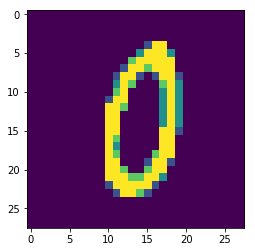

In [3]:
#Get the mnist data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

#set the parameters
image_size = 28
labels_size = 10
learning_rate = 0.01
steps_number = 1000
batch_size = 100

# In this example, we limit mnist data
Xtr, Ytr = mnist.train.next_batch(5000) #5000 for training (nn candidates)
Xte, Yte = mnist.test.next_batch(200) #200 for testing


# Placeholder is a value that we input when we ask TensorFlow to run a computation.# Place 
x = tf.placeholder(tf.float32, shape = [None,784])
y_ = tf.placeholder(tf.float32, shape = [None, 10])

sample_image = mnist.train.next_batch(1)[0]
sample_image = sample_image.reshape([28, 28])
plt.imshow(sample_image)

# Functions for weights
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

# Function for bias
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Functions for convolution with stride = 1 and padding = 0
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

# Function for max pooling over 2*2 blocks
def max_pooling_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

#plt.imshow(image.reshape((28,28)), cmap='Greys')

In [4]:
# The architecture is similar to https://www.tensorflow.org/get_started/mnist/pros

# Input layer where single input image shape is (1,784)
x_image = tf.reshape(x, [-1,28,28,1])

# Convolution layer 1 - 32 x 5 x 5 
# Conv -> BatchNorm -> Relu -> Max_pool
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x_conv1 = conv2d(x_image, W_conv1) + b_conv1
y1 = tf.nn.relu(tf.layers.batch_normalization(x_conv1))
x_pool1 = max_pooling_2x2(y1)

# Conv layer 2 - 64 x 5 x 5
# Conv -> BatchNorm -> Relu -> Max_pool
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
x_conv2 = conv2d(x_pool1, W_conv2) + b_conv2
y2 = tf.nn.relu(tf.layers.batch_normalization(x_conv2))
x_pool2 = max_pooling_2x2(y2)

# Flatten 
x_flat = tf.reshape(x_pool2, [-1, 7 * 7 * 64])

# Dense fully connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024]) # max pooling reduced image to 7x7
b_fc1 = bias_variable([1024])
x_fc1 = tf.nn.relu(tf.layers.batch_normalization(tf.matmul(x_flat, W_fc1) + b_fc1))

# Dropout
keep_prob = tf.placeholder(tf.float32)
x_fc1_drop = tf.nn.dropout(x_fc1, keep_prob)

# Classification layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(x_fc1_drop, W_fc2) + b_fc2

In [6]:
# Probabilities output from model
y = tf.nn.softmax(y_conv)

# Loss and Adam optimizer
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

In [7]:
# Test accuracy of model# Test  
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [8]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [9]:
# Train model
for i in tqdm(range(1000)):
    batch = mnist.train.next_batch(100)
    if i%200 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("Epoch %d, training accuracy %g"%(i, train_accuracy))

    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.4})


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0, training accuracy 0.23


 20%|██        | 200/1000 [01:24<05:39,  2.35it/s]

Epoch 200, training accuracy 0.94


 40%|████      | 400/1000 [02:49<04:14,  2.35it/s]

Epoch 400, training accuracy 0.95


 60%|██████    | 600/1000 [04:14<02:49,  2.35it/s]

Epoch 600, training accuracy 0.97


 80%|████████  | 800/1000 [05:40<01:25,  2.35it/s]

Epoch 800, training accuracy 0.97


100%|██████████| 1000/1000 [07:07<00:00,  2.34it/s]


In [10]:
print(train_accuracy)
print((mnist.test.labels[:,2]))
#Save model
saver = tf.train.Saver()
saver.save(sess, "./classifier")

0.97
[0. 0. 0. ... 0. 0. 0.]


'./classifier'

In [11]:
# Fetch 10 2's images
index_mask = np.where(mnist.test.labels[:, 2])[0]
print(index_mask)
subset_mask = np.random.choice(index_mask, 10)
print(subset_mask)

[  16   25   28 ... 9976 9987 9989]
[4925  704 3381 1954 7267 4553 1553 9102 8891 9710]


In [12]:
# Display the labels of the selected images
original_images = mnist.test.images[subset_mask]
original_labels = mnist.test.labels[subset_mask]
original_labels

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

In [13]:
# Predict the model on the selected 10 2's samples# Predic 
prediction = tf.argmax(y,1)
prediction_val = prediction.eval(feed_dict={x: original_images, keep_prob: 1.0}, session=sess)
print("predictions", prediction_val)
probabilities = y
probabilities_val = probabilities.eval(feed_dict={x: original_images, keep_prob: 1.0}, session=sess)
print ("probabilities", probabilities_val)

('predictions', array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))
('probabilities', array([[1.96349191e-07, 9.72802994e-08, 9.99975801e-01, 1.34451375e-06,
        6.35685282e-08, 6.07297190e-09, 1.97090046e-07, 1.55993393e-06,
        2.03088621e-05, 4.46419051e-07],
       [8.48469135e-05, 1.22998562e-03, 9.87301588e-01, 7.66188547e-04,
        2.45977867e-06, 4.56309817e-06, 4.84290831e-05, 1.62100579e-04,
        1.03789745e-02, 2.08892052e-05],
       [4.08220740e-06, 1.00414822e-04, 9.97951567e-01, 1.36109593e-03,
        1.11832684e-07, 1.04807964e-06, 4.49419161e-07, 4.83789685e-04,
        9.25677959e-05, 4.84824022e-06],
       [2.23880008e-04, 2.34390518e-06, 9.99373138e-01, 1.91191066e-04,
        2.71834483e-06, 8.50693978e-05, 1.14073600e-05, 8.79870277e-05,
        1.21786752e-05, 1.00767375e-05],
       [2.95604764e-06, 7.96677625e-07, 9.99906063e-01, 7.25903328e-06,
        1.96749370e-05, 5.15450402e-08, 2.79897768e-06, 9.19672584e-06,
        4.92448407e-06, 4.62926509e-05],
  

('Correct label', 2)
('Predicted label:', 2)
('Confidence:', 0.9999758)


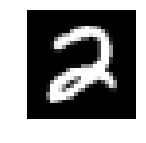

('Correct label', 2)
('Predicted label:', 2)
('Confidence:', 0.9873016)


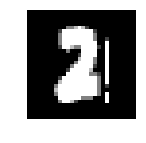

('Correct label', 2)
('Predicted label:', 2)
('Confidence:', 0.99795157)


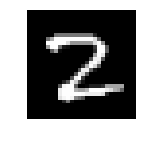

('Correct label', 2)
('Predicted label:', 2)
('Confidence:', 0.99937314)


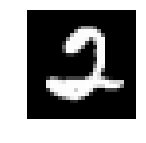

('Correct label', 2)
('Predicted label:', 2)
('Confidence:', 0.99990606)


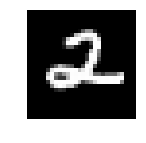

('Correct label', 2)
('Predicted label:', 2)
('Confidence:', 0.999936)


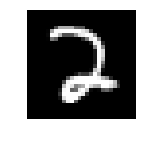

('Correct label', 2)
('Predicted label:', 2)
('Confidence:', 0.9093224)


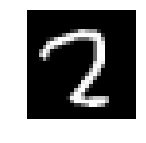

('Correct label', 2)
('Predicted label:', 2)
('Confidence:', 0.9929731)


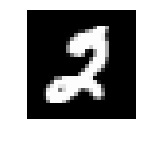

('Correct label', 2)
('Predicted label:', 2)
('Confidence:', 0.998852)


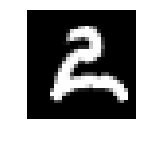

('Correct label', 2)
('Predicted label:', 2)
('Confidence:', 0.99388003)


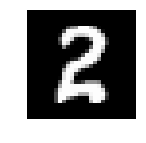

In [14]:
# Show the original images, correct, predicted label and confidence
for i in range(0, 10):
    print('Correct label', np.argmax(original_labels[i]))
    print('Predicted label:', prediction_val[i])
    print('Confidence:', np.max(probabilities_val[i]))
    plt.figure(figsize=(2, 2))
    plt.axis('off')
    plt.imshow(original_images[i].reshape([28, 28]),cmap = "gray")
    plt.show()

In [15]:
# Set the target label as 6
target_number = 6
target_labels = np.zeros(original_labels.shape)
target_labels[:, target_number] = 1

In [16]:
target_labels

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])

In [17]:
img_gradient = tf.gradients(cross_entropy, x)[0]

In [18]:
step_size  = 0.5 #The amount to wiggle towards the gradient of target class.
steps = 10

In [19]:
#Targeted attack using Fast gradient sign method inspired from http://blog.ycombinator.com/how-adversarial-attacks-work/#Targete 
# and http://karpathy.github.io/2015/03/30/breaking-convnets/
adversarial_img = original_images.copy()
for i in range(0, steps):
    gradient = img_gradient.eval({x: adversarial_img, y_: target_labels, keep_prob: 1.0})
    #Update using value of gradient
    adversarial_img = adversarial_img - step_size * gradient
    prediction = tf.argmax(y,1)
    prediction_val = prediction.eval(feed_dict={x: adversarial_img, keep_prob: 1.0}, session=sess)
    print("predictions", prediction_val)
    probabilities = y
    probabilities_val = probabilities.eval(feed_dict={x: adversarial_img, keep_prob: 1.0}, session=sess)
    print('Confidence 2:', probabilities_val[:, 2])
    print('Confidence 6:', probabilities_val[:, 6])

('predictions', array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))
('Confidence 2:', array([0.9998406 , 0.9467898 , 0.99398416, 0.9967961 , 0.99945825,
       0.99981993, 0.7674244 , 0.9730647 , 0.9948192 , 0.9725176 ],
      dtype=float32))
('Confidence 6:', array([4.1614312e-06, 5.0363934e-04, 7.4737086e-06, 2.4054844e-04,
       5.3162992e-05, 3.6868778e-06, 3.7352653e-05, 1.3216966e-04,
       1.5324405e-03, 1.7005303e-04], dtype=float32))
('predictions', array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))
('Confidence 2:', array([0.9991673 , 0.8331668 , 0.9813083 , 0.9778621 , 0.9964563 ,
       0.9994153 , 0.61528224, 0.901837  , 0.9642735 , 0.88394135],
      dtype=float32))
('Confidence 6:', array([6.9672336e-05, 4.3635354e-03, 1.1444363e-04, 5.5032871e-03,
       1.0660667e-03, 9.4879353e-05, 2.8105176e-04, 3.2003936e-03,
       2.3129202e-02, 2.6766141e-03], dtype=float32))
('predictions', array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))
('Confidence 2:', array([0.9961981 , 0.67727256, 0.9477887 , 0.8692772 , 

In [20]:
step_size  = 0.02
steps = 10

In [21]:
adversarial_img = original_images.copy()
adv_img_hist = list()
prob2_hist = list()
prob6_hist = list()
for i in range(0, steps):
    gradient = img_gradient.eval({x: adversarial_img, y_: target_labels, keep_prob: 1.0})
    # Update using sign of gradient and decreasing the step size
    adversarial_img = adversarial_img - step_size * np.sign(gradient)
    adv_img_hist.append(adversarial_img)
    prediction = tf.argmax(y,1)
    prediction_val = prediction.eval(feed_dict={x: adversarial_img, keep_prob: 1.0}, session=sess)
    print("predictions", prediction_val)
    probabilities = y
    probabilities_val = probabilities.eval(feed_dict = {x: adversarial_img, keep_prob: 1.0}, session=sess)
    print('Confidence 2:', probabilities_val[:, 2])
    print('Confidence 6:', probabilities_val[:, 6])
prob2_hist.append(probabilities_val[:,2])
prob6_hist.append(probabilities_val[:,6])

('predictions', array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))
('Confidence 2:', array([0.9998708 , 0.9478486 , 0.99398005, 0.99743783, 0.9994808 ,
       0.9998666 , 0.74250674, 0.97507024, 0.9951321 , 0.9795675 ],
      dtype=float32))
('Confidence 6:', array([2.8261031e-06, 4.6036276e-04, 5.9947347e-06, 1.5738267e-04,
       3.5066976e-05, 2.1821083e-06, 3.3683020e-05, 8.4671701e-05,
       1.2844393e-03, 1.0127047e-04], dtype=float32))
('predictions', array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))
('Confidence 2:', array([0.99940276, 0.78895473, 0.98184574, 0.9862884 , 0.9970811 ,
       0.9995939 , 0.5768852 , 0.9248792 , 0.9687421 , 0.9220613 ],
      dtype=float32))
('Confidence 6:', array([4.8540060e-05, 4.7836322e-03, 9.1942617e-05, 2.8167905e-03,
       5.6420459e-04, 4.4314718e-05, 3.1380350e-04, 1.3861674e-03,
       1.8831667e-02, 1.4716444e-03], dtype=float32))
('predictions', array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))
('Confidence 2:', array([0.99686086, 0.6498545 , 0.943456  , 0.9173142 , 

In [22]:
print("Probability of 2 in selected samples ",prob2_hist)
print("Probability of 6 in selected samples ",prob6_hist)

('Probability of 2 in selected samples ', [array([1.0692575e-02, 5.0500932e-04, 8.3468587e-04, 1.8872427e-04,
       3.0064286e-04, 1.7681288e-03, 1.3613846e-02, 3.2632539e-04,
       2.1942973e-05, 1.7899838e-03], dtype=float32)])
('Probability of 6 in selected samples ', [array([0.9851585 , 0.99869734, 0.99793845, 0.99955136, 0.9993843 ,
       0.9977223 , 0.9527165 , 0.99898297, 0.99994624, 0.9951314 ],
      dtype=float32)])


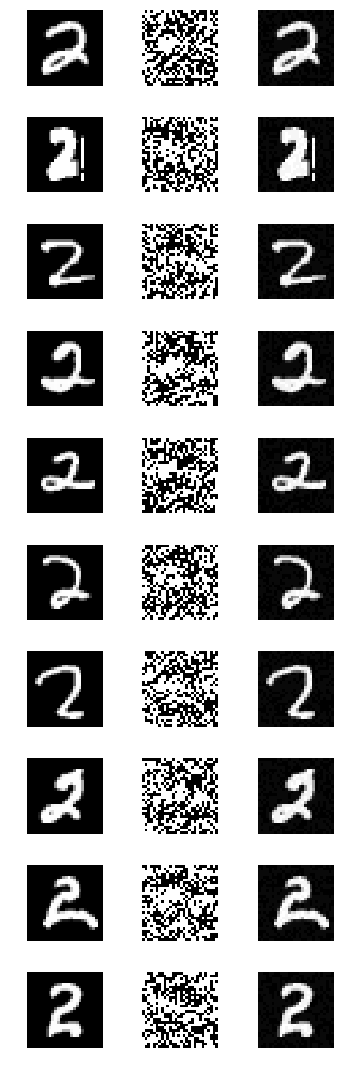

In [23]:
# Generate the image of 10 samples with original_image, delta and adversarial image
f, axarr = plt.subplots(10, 3, figsize=(5,15))
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 250
for i in range(10):
    axarr[i,0].set_axis_off()
    axarr[i,1].set_axis_off()
    axarr[i,2].set_axis_off()
    axarr[i,0].imshow(original_images[i].reshape([28, 28]), cmap = "gray")
    axarr[i,1].imshow((adv_img_hist[0][i] - original_images[i]).reshape([28, 28]), cmap = "gray")
    axarr[i,2].imshow((adv_img_hist[0][i]).reshape([28, 28]), cmap="gray")
    
plt.tight_layout()
plt.show()
f.savefig("result.png")